In [1]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re
import string
import pandas as pd

In [2]:
# import dataset
df = pd.read_csv("dataset.csv")
df.head()

,Emotion,Text
0,neutral,@dannycastillo Houston ticket neitu nen kan in...
1,neutral,cant fall muhil thei lo
2,neutral,Balisage Markup Conference 2009 Program-a No T...
3,neutral,@cynthia_123 i muhil thei lo
4,neutral,Bus bl***y chu ka miss ta!!!!!!!!


In [3]:
#shuffle the dataset
df = df.sample(frac = 1)

In [4]:
# text processing function 
def clean_text(text):
    # to lower case
    text = text.lower()
    # remove links
    text = re.sub('https:\/\/\S+', '', text) 
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
    # remove next line     
    text = re.sub(r'[^ \w\.]', '', text) 
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    
    return text
# Create a new column called "Text" for collecting clean text
df['Text'] = df.Text.apply(lambda x: clean_text(x))

In [5]:
# Stop word in  mizo language
stop_words  = "a, i si a min em  le tak te e in he u tih ka va keimah keini kan keimahni nangmah nangma nangmahni ngei pawh ani amah a ta chu ni chumi anni an engnge khawi tunge hei sawmi hengte hi tawh nei ti mek leh mahse chuan emaw avang angin hma laiin tan hmunah tu nen lam kalh karah chhungah tlang hmaah hnuah chungah hnuai ah atangin chunglam hnuailam chhung pawn titawp hla zawk tichuan vawikhat hetah sawtah engtikah khawnge engati nge engtin zavai engpawh pahnihin vek tlem belh ber thildang engemawzat chutiang aih ve chauh inang chuvangin aiin lutuk thei duhdan chiah don tur tunah"

# Convert to lower case
stop_words = stop_words.lower()

# convert string to list
def Convert(string):
    li = list(string.split(" "))
    return li


stop_word_list = Convert(stop_words)

# Remove stop words
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word_list)]))

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the labels
labels = df["Emotion"].apply(lambda x: x.split(','))

# Binarize the labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)

# The hyperparameters required to tune the network.
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Tokenize and pad the sequences
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(df["Text"])
sequences = tokenizer.texts_to_sequences(df["Text"])
padded_sequences = pad_sequences(sequences,maxlen=max_length,truncating=trunc_type)
max_length = padded_sequences.shape[1]

# Compute the TF-IDF features for the padded sequences
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform([' '.join([str(word) for word in sequence]) for sequence in padded_sequences])
tfidf_matrix_dense = tfidf_matrix.toarray()

# Reshape the tfidf_matrix_dense to a 3D tensor
tfidf_matrix_3d = tfidf_matrix_dense.reshape((tfidf_matrix_dense.shape[0], 1, tfidf_matrix_dense.shape[1]))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_3d, y, test_size=0.2)

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=64, input_shape=(tfidf_matrix_3d.shape[1], tfidf_matrix_3d.shape[2]), dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=y.shape[1], activation='softmax'))

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))



Epoch 1/10
299/299 [==============================] - 61s 141ms/step - loss: 1.4503 - accuracy: 0.3755 - val_loss: 1.2762 - val_accuracy: 0.4717
Epoch 2/10
299/299 [==============================] - 38s 126ms/step - loss: 1.1304 - accuracy: 0.5353 - val_loss: 1.0803 - val_accuracy: 0.5816
Epoch 3/10
299/299 [==============================] - 39s 131ms/step - loss: 0.8522 - accuracy: 0.6715 - val_loss: 1.0318 - val_accuracy: 0.6210
Epoch 4/10
299/299 [==============================] - 38s 126ms/step - loss: 0.6939 - accuracy: 0.7486 - val_loss: 1.0294 - val_accuracy: 0.6226
Epoch 5/10
299/299 [==============================] - 39s 129ms/step - loss: 0.6035 - accuracy: 0.7891 - val_loss: 1.0217 - val_accuracy: 0.6319
Epoch 6/10
299/299 [==============================] - 40s 133ms/step - loss: 0.5410 - accuracy: 0.8174 - val_loss: 1.0247 - val_accuracy: 0.6436
Epoch 7/10
299/299 [==============================] - 40s 134ms/step - loss: 0.4857 - accuracy: 0.8307 - val_loss: 1.0865 - val_ac

In [9]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

75/75 [==============================] - 1s 16ms/step - loss: 1.0865 - accuracy: 0.6453
Test Loss: 1.0864506959915161, Test Accuracy: 0.645283043384552


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the predicted and actual labels
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")

75/75 [==============================] - 2s 17ms/step
Accuracy: 0.6452830188679245
Precision: 0.6512456138259554
Recall: 0.6452830188679245
F1 score: 0.6454785190527237


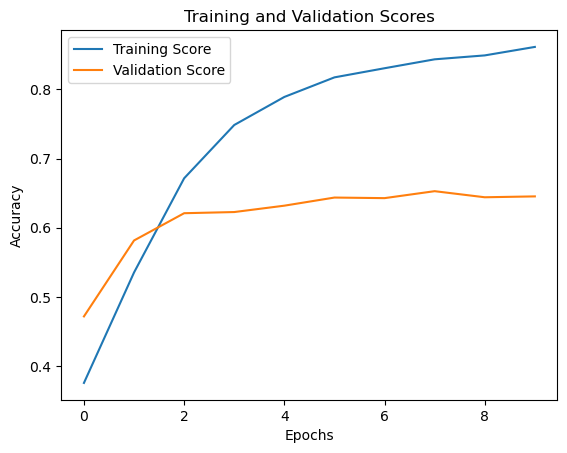

In [11]:
import matplotlib.pyplot as plt

# Get the training and validation scores from the history object returned by the fit() method
train_scores = history.history['accuracy']
val_scores = history.history['val_accuracy']

# Plot the training and validation scores on a line graph
plt.plot(train_scores, label='Training Score')
plt.plot(val_scores, label='Validation Score')
plt.title('Training and Validation Scores')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [12]:
def predict_emotion(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, truncating=trunc_type)
    tfidf_sequence = tfidf.transform([' '.join([str(word) for word in sequence[0]])])
    tfidf_sequence_dense = tfidf_sequence.toarray()
    tfidf_sequence_3d = tfidf_sequence_dense.reshape((1, 1, tfidf_sequence_dense.shape[1]))
    prediction = model.predict(tfidf_sequence_3d)
    max_index = np.argmax(prediction[0])
    predicted_label = mlb.classes_[max_index]
    return predicted_label


In [13]:
predict_emotion("Ka lom Loh")

1/1 [==============================] - 0s 32ms/step


'anger'